# Remap meridional volume transport in the density space onto the depth space

This notebook is converted from plt_vh_rho_remap.py, which tries to remap meridional volume transport in the density space onto the depth space. 

Aiming to match the remapped volume transport with calculated volume transport in the depth space. 

## Last updated 10 October 2017.

In [2]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

v45 - wdx1: output017 (y50)  wdx2: output024 (y65)  wdx3: output031 (y80) 

v57 - wdx1: output013 (y50)  wdx2: output020 (y65)  wdx3: output027 (y80)

v59 - wdx1: output013 (y50)  wdx2: output020 (y65)  wdx3: output027 (y80)

In [3]:
data = nc.Dataset('/short/v45/lxy581/mom6/archive/so_mom6_v45/output031/prog_rho.nc','r')
rhoi = nc.Dataset('/short/v45/lxy581/mom6/archive/so_mom6_v45/output031/prog.nc','r')
coord = nc.Dataset('/short/v45/lxy581/mom6/input/so_mom6_v39/coord.nc','r')

In [4]:
xq = data.variables['xq'][:]        # uh_rho
yh = data.variables['yh'][:]        # uh_rho,h_rho
xh = data.variables['xh'][:]        # vh_rho,h_rho
yq = data.variables['yq'][:]        # vh_rho
zl = data.variables['zl'][:]
t  = rhoi.variables['Time'][:]
rhol = coord.variables['Layer'][:]

## Meridional volume transport in the density space - vh_rhoc

Calculate the time-mean, zonal- and vertical- integrated meridional volume transport in the density space.

In [6]:
ny = np.size(yq)
nz = np.size(zl)
nt = np.size(t)

In [8]:
vh_rho4 = data.variables['vh_rho'][:,:,:,:]
vh_rho4 = vh_rho4.filled(np.nan)
# time mean
vh_rho3 = np.nanmean(vh_rho4,axis=0)
# zonal integral
vh_rho2 = np.nansum(vh_rho3,axis=-1)
# vertical cumulative sum (integrate from the bottom)
vh_rhoc = vh_rho2[::-1,...].cumsum(axis=0)[::-1,...] 

# mask vh_rhoc in first few layers - if vh_rhoc was repeated by the layer above, mask the shallower layer.
# - if the volume transport is zero, the layer above will inherit the volume transport from the layer below since 
# - cumulative sum is integrated from the bottom
for j in xrange(0,ny):
    for k in xrange(0,nz-1):
        if vh_rhoc[k,j] == vh_rhoc[k+1,j]:
            vh_rhoc[k,j] = 0.0

## Meridional volume transport in the depth space - vh_depc

Remap vh_rhoc onto the depth space, i.e., vh_rhoc(rhol,yq) -> vh_depc(zl,yq). 

Finding the density layers in the depth space and then matching density layers with depth layers.

Get the zonal- and time- mean density structure in the depth space. 

Get ready for matching densities!

In [9]:
rho3 = np.zeros((1,nz,ny))
rhox = np.full((1,nz,ny),np.nan)

for k in xrange(0,nt):
    #print k
    rho  = rhoi.variables['rhoinsitu'][k,:,:,:]
    rhox[0,:,:] = np.nanmean(rho,axis=-1) # zonal-mean
    rho3 = np.append(rho3,rhox,0)

rho3 = rho3[1:,:,:]
rho2 = np.nanmean(rho3,axis=0)

# mask rho2 below topography - if rho2 was repeated by the layer below, mask the lower layer.
for j in xrange(0,ny):
    for k in xrange(0,nz-1):
        if rho2[k,j] == rho2[k+1,j]:
            rho2[k+1,j] = np.nan

In [10]:
vh_depc = np.full((nz,ny),np.nan)
# find corresponding rhol for vh_rhoc, match them with rho2, and get index in the depth space
for j in xrange(0,ny):
    for kr in xrange(0,nz-1):
        if vh_rhoc[kr,j] != 0.0:
            rho_min = rhol[kr]
            rho_max = rhol[kr+1]
            for kz in xrange(0,nz):
                if rho2[kz,j]>rho_min and rho2[kz,j]<rho_max:
                    vh_depc[kz,j] = vh_rhoc[kr,j]

In [11]:
%matplotlib inline

(array([ 1035. ,  1035.5,  1036. ,  1036.5,  1037. ]),
 <a list of 5 Text yticklabel objects>)

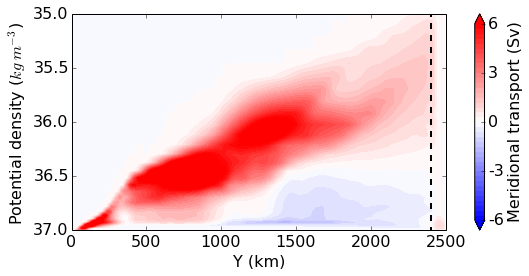

In [12]:
# Fig. 1 - plot meridional volume transport in density-y space
plt.figure(1,figsize=(8,5))

vh_level = np.arange(-6e+6,6e+6+0.3e+6,0.3e+6)
vh_ticks = np.arange(-6e+6,6e+6+3e+6,3e+6)

pc = plt.contourf(yq,rhol,vh_rhoc,cmap=plt.cm.bwr,levels=vh_level,extend='both')
plt.plot([1150,1150],[0,4000],linewidth=2.0,linestyle='--',color='k')
cb = plt.colorbar(pc,ticks=vh_ticks)
plt.gca().set_xticks(np.arange(-1250,1250 + 500,500))
plt.gca().set_xticklabels(['0','500','1000','1500','2000','2500'])
plt.gca().set_ylim([1035.0,1037.0])
plt.gca().set_yticks(np.arange(1035.0,1037.0 + 0.5,0.5))
plt.gca().set_yticklabels(['35.0','35.5','36.0','36.5','37.0'])
plt.gca().invert_yaxis()
plt.gca().set_position([0.15,0.2,0.65,0.6])
cb.ax.set_position([0.85,0.2,0.03,0.6])
cb.ax.set_yticklabels(['-6','-3','0','3','6'])
cb.set_label('Meridional transport (Sv)',y=0.5,fontsize=16)
cb.ax.tick_params(labelsize=16)
plt.xlabel('Y (km)',fontsize=16)
plt.ylabel('Potential density ($kg\ m^{-3}$)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.savefig('/short/v45/lxy581/mom6/diag/v45_vh_rho_y80_wdx3.png',dpi=600)

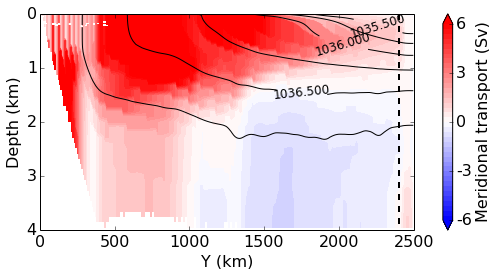

In [13]:
# Fig. 2 - plot meridional volume transport in depth-y space [remapped]
plt.figure(2,figsize=(8,5))

r_level = np.arange(1035.5,1037.0,0.25)

pcf = plt.contourf(yq,zl,vh_depc,cmap=plt.cm.bwr,levels=vh_level,extend='both')
pc  = plt.contour(yh,zl,rho2,colors='k',levels=r_level,extend='both')
manual_locations = [(1000,300),(750,800),(500,1500)]
plt.clabel(pc,r_level[::2],inline=1,fontsize=12,manual=manual_locations)
plt.plot([1150,1150],[0,4000],linewidth=2.0,linestyle='--',color='k')
cb = plt.colorbar(pcf,ticks=vh_ticks)
plt.gca().invert_yaxis()
plt.gca().set_xticks(np.arange(-1250,1250 + 500,500))
plt.gca().set_xticklabels(['0','500','1000','1500','2000','2500'])
plt.gca().set_yticks(np.arange(0,4000 + 1000,1000))
plt.gca().set_yticklabels(['0','1','2','3','4'])
plt.gca().set_position([0.15,0.2,0.65,0.6])
cb.ax.set_position([0.85,0.2,0.03,0.6])
cb.ax.set_yticklabels(['-6','-3','0','3','6'])
cb.set_label('Meridional transport (Sv)',y=0.5,fontsize=16)
cb.ax.tick_params(labelsize=16)
plt.xlabel('Y (km)',fontsize=16)
plt.ylabel('Depth (km)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.savefig('/short/v45/lxy581/mom6/diag/v45_vh_remap_y80_wdx3.png',dpi=600)

plt.show()